The following notebook will examine the already prepared data and will provide answers to the business questions addressed:
- When are the busiest time in Boston? 
- Which are the busiest neighbourhoods in Boston, in terms of AirBNB density?
- Can we understand the features of the AirBNBs that define the price?

In [1]:
#imports 
import pandas as pd
import numpy as np 
import math

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick 
import matplotlib.dates as mdates
from matplotlib.ticker import PercentFormatter, FuncFormatter
%matplotlib inline
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)
from cycler import cycler
import joblib

import seaborn as sns
sns.set()

import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from textacy import preprocessing
import textacy

import spacy
nlp = spacy.load('en_core_web_sm')

# environment settings
pd.set_option('display.max_column',None)
pd.set_option('display.max_rows',None)

In [2]:
#read processed data
calendar = pd.read_pickle('/Users/asyagadzhalova/Documents/GitHub/Boston-Airbnb-data/src/data/processed/calendar.pkl')
cal_month_total=pd.read_pickle('/Users/asyagadzhalova/Documents/GitHub/Boston-Airbnb-data/src/data/processed/calendar_metrics_monthly.pkl')
cal_metrics_total=pd.read_pickle('/Users/asyagadzhalova/Documents/GitHub/Boston-Airbnb-data/src/data/processed/calendar_metrics.pkl')
listings = pd.read_pickle('/Users/asyagadzhalova/Documents/GitHub/Boston-Airbnb-data/src/data/processed/listings.pkl')

The business problems I want to address:
- When are the busiest time in Boston? 
- Which are the busiest neighbourhoods in Boston, in terms of AirBNB density?
- Can we understand the features of the AirBNBs that define the price?
    

## 1. Which are the busiest periods in Boston?

Calendar data provides information for each listing for each day throughout 365 days /rolling year/  whether the listing was taken or not. Based on it, I have calculated an occupancy metrics - ratio between the number of reserved days and total number of days per listing, on monthly and yearly base.

In [3]:
#dataset with occupancy metrics per month
cal_month_total.head()

,listing_id,month,total_days,busy_days,occupancy_metrics
0,3353,2016-09,25,25.0,100.000000
1,3353,2016-10,31,31.0,100.000000
2,3353,2016-11,30,30.0,100.000000
3,3353,2016-12,31,30.0,96.774194
4,3353,2017-01,31,0.0,0.000000


In [4]:
#dataset with occupancy metrics for total period
cal_metrics_total.head()

,listing_id,total_days,busy_days,occupancy_metrics
0,3353,365,116.0,32.0
1,5506,365,21.0,6.0
2,6695,365,41.0,11.0
3,6976,365,46.0,13.0
4,8792,365,117.0,32.0


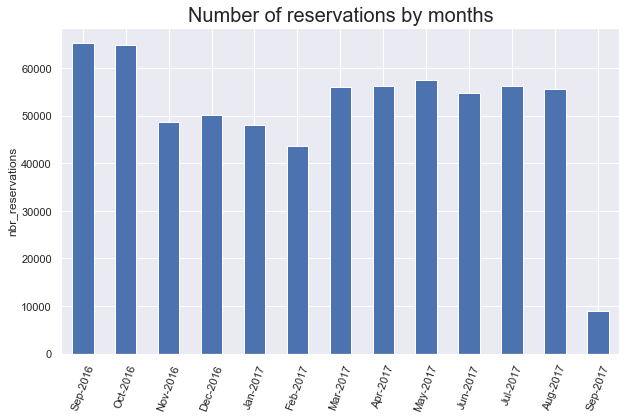

In [5]:
fig, ax = plt.subplots(figsize=(10,6))
cal_month = calendar[calendar['available']=='f']['date'].value_counts().resample('M').sum()
cal_month.plot(kind = 'bar', color='b')
plt.xticks(rotation=70)
ax.set_xticklabels(cal_month.index.strftime('%b-%Y'))
plt.ylabel('nbr_reservations')
plt.title('Number of reservations by months', size = 20);
#plt.legend(bbox_to_anchor=(1, 1),title = 'Vendor')

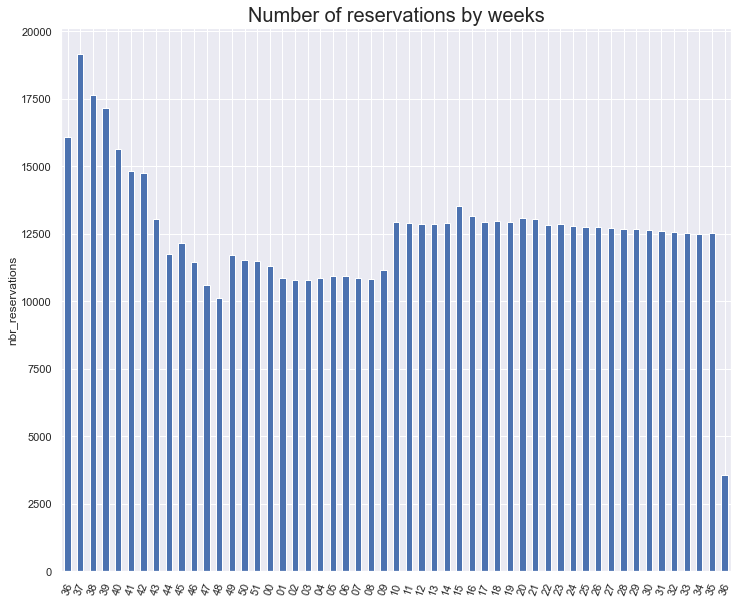

In [6]:
fig, ax = plt.subplots(figsize=(12,10))
cal_month = calendar[calendar['available']=='f']['date'].value_counts().resample('W').sum()
cal_month.plot(kind = 'bar', color='b')
plt.xticks(rotation=70)
ax.set_xticklabels(cal_month.index.strftime('%W'))
plt.ylabel('nbr_reservations')
plt.title('Number of reservations by weeks', size = 20);
#plt.legend(bbox_to_anchor=(1, 1),title = 'Vendor')

We see a significant spike in Sep&Oct months vs the rest of the year. The split by weeks shows that week 37 /12 Sept 2016-18 Sept 2016/ is the busiest week in the year. The number of listings is stable across the rolling year -> the spike in reservations in weeks between 36 and 42 is due to more reservations. Since there is no big event taking place, I would suggest the busiest time of year in weeks 36&37 matches the start of the academic year for MIT /which was 7 Sept 2016/. 

In [7]:
cal_month_total.groupby(['month']).agg({'listing_id':'count'})

,listing_id
month,
2016-09,3585
2016-10,3585
2016-11,3585
2016-12,3585
2017-01,3585
2017-02,3585
2017-03,3585
2017-04,3585
2017-05,3585


In [8]:
#Complete capacity of airbnbs:
calc_capacity = cal_month_total.groupby(['month']).agg({'total_days':'sum','busy_days':'sum'}).reset_index()

In [9]:
calc_capacity['free_capacity'] = round(1 - calc_capacity['busy_days']/calc_capacity['total_days'],2)

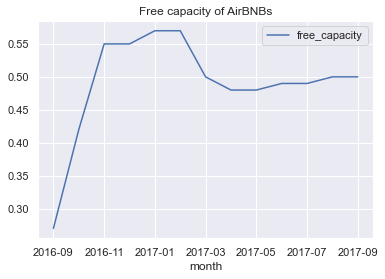

In [10]:
calc_capacity.plot(x = 'month',y = 'free_capacity', kind='line',title = 'Free capacity of AirBNBs',figsize=(6,4));

In [11]:
calc_capacity[['month','free_capacity']]

,month,free_capacity
0,2016-09,0.27
1,2016-10,0.42
2,2016-11,0.55
3,2016-12,0.55
4,2017-01,0.57
5,2017-02,0.57
6,2017-03,0.50
7,2017-04,0.48
8,2017-05,0.48
9,2017-06,0.49


In [12]:
calc_capacity['busy_days'].sum()/calc_capacity['total_days'].sum()

0.5086398807817963

## Which are the busiest neighbourhoods in Boston?

For neighbourhood, I am using column neighbourhood_cleansed from the listings dataset.

In [13]:
listings.head()

,id,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_identity_verified,neighbourhood_cleansed,city,latitude,longitude,property_type,room_type,bathrooms,bedrooms,beds,bed_type,amenities,security_deposit,cleaning_fee,minimum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy,reviews_per_month,days_operation,price_per_person
0,12147973,1,NaN,NaN,NaN,0,1,0,Roslindale,Boston,42.282619,-71.133068,House,Entire home/apt,1.5,2.0,3.0,Real Bed,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",0.0,35.0,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,moderate,NaN,511,50.00
1,3075044,1,within an hour,100%,100%,0,1,1,Roslindale,Boston,42.286241,-71.134374,Apartment,Private room,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",""Air Conditio...",95.0,10.0,2,36,94.0,10.0,9.0,10.0,10.0,9.0,9.0,moderate,1.30,1553,32.50
2,6976,1,within a few hours,100%,88%,1,1,1,Roslindale,Boston,42.292438,-71.135765,Apartment,Private room,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",""Wireless Internet"",""Air Condit...",0.0,0.0,3,41,98.0,10.0,9.0,10.0,10.0,9.0,10.0,moderate,0.47,2676,41.67
3,1436513,1,within a few hours,100%,50%,0,1,0,Roslindale,Boston,42.281106,-71.121021,House,Private room,1.0,1.0,2.0,Real Bed,"{TV,Internet,""Wireless Internet"",""Air Conditio...",100.0,50.0,1,1,100.0,10.0,10.0,10.0,10.0,10.0,10.0,moderate,1.00,1235,37.50
4,7651065,1,within an hour,100%,100%,1,1,1,Roslindale,Boston,42.284512,-71.136258,House,Private room,1.5,1.0,2.0,Real Bed,"{Internet,""Wireless Internet"",""Air Conditionin...",0.0,15.0,2,29,99.0,10.0,10.0,10.0,10.0,9.0,10.0,flexible,2.25,850,26.33


In [14]:
listings['neighbourhood_cleansed'].value_counts()

Jamaica Plain              343
South End                  326
Back Bay                   302
Fenway                     290
Dorchester                 269
Allston                    260
Beacon Hill                194
Brighton                   185
South Boston               174
Downtown                   172
East Boston                150
Roxbury                    144
North End                  143
Mission Hill               124
Charlestown                111
South Boston Waterfront     83
Chinatown                   71
Roslindale                  56
West End                    49
West Roxbury                46
Hyde Park                   31
Mattapan                    24
Bay Village                 24
Longwood Medical Area        9
Leather District             5
Name: neighbourhood_cleansed, dtype: int64

### Add data for occupancy metrics to listings

In [15]:
cal_metrics_total.shape

(3585, 4)

In [16]:
cal_metrics_total.head()

,listing_id,total_days,busy_days,occupancy_metrics
0,3353,365,116.0,32.0
1,5506,365,21.0,6.0
2,6695,365,41.0,11.0
3,6976,365,46.0,13.0
4,8792,365,117.0,32.0


In [17]:
data = listings.merge(cal_metrics_total, how = 'inner', left_on = 'id', right_on = 'listing_id')

In [18]:
data.shape

(3585, 38)

In [19]:
data.head()

,id,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_identity_verified,neighbourhood_cleansed,city,latitude,longitude,property_type,room_type,bathrooms,bedrooms,beds,bed_type,amenities,security_deposit,cleaning_fee,minimum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy,reviews_per_month,days_operation,price_per_person,listing_id,total_days,busy_days,occupancy_metrics
0,12147973,1,NaN,NaN,NaN,0,1,0,Roslindale,Boston,42.282619,-71.133068,House,Entire home/apt,1.5,2.0,3.0,Real Bed,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",0.0,35.0,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,moderate,NaN,511,50.00,12147973,365,365.0,100.0
1,3075044,1,within an hour,100%,100%,0,1,1,Roslindale,Boston,42.286241,-71.134374,Apartment,Private room,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",""Air Conditio...",95.0,10.0,2,36,94.0,10.0,9.0,10.0,10.0,9.0,9.0,moderate,1.30,1553,32.50,3075044,365,6.0,2.0
2,6976,1,within a few hours,100%,88%,1,1,1,Roslindale,Boston,42.292438,-71.135765,Apartment,Private room,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",""Wireless Internet"",""Air Condit...",0.0,0.0,3,41,98.0,10.0,9.0,10.0,10.0,9.0,10.0,moderate,0.47,2676,41.67,6976,365,46.0,13.0
3,1436513,1,within a few hours,100%,50%,0,1,0,Roslindale,Boston,42.281106,-71.121021,House,Private room,1.0,1.0,2.0,Real Bed,"{TV,Internet,""Wireless Internet"",""Air Conditio...",100.0,50.0,1,1,100.0,10.0,10.0,10.0,10.0,10.0,10.0,moderate,1.00,1235,37.50,1436513,365,267.0,73.0
4,7651065,1,within an hour,100%,100%,1,1,1,Roslindale,Boston,42.284512,-71.136258,House,Private room,1.5,1.0,2.0,Real Bed,"{Internet,""Wireless Internet"",""Air Conditionin...",0.0,15.0,2,29,99.0,10.0,10.0,10.0,10.0,9.0,10.0,flexible,2.25,850,26.33,7651065,365,31.0,8.0


To approach the question, I have designed a metrics called occupancy metrics, that is a ratio between the number of reserved days and the total number of days available for reservation per listing, on monthly and yearly base/rolling 365 days/. From the chart above the occupancy metrics is 51%.

In [20]:
df = data.groupby(['neighbourhood_cleansed']).agg({'id':'count','busy_days':'sum','total_days':'sum'}).reset_index()

In [21]:
df['occupancy'] = round(df['busy_days']/df['total_days']*100,2)
#df['avg_occupancy_per_listing'] = round(df['occupancy']/id,2)

In [22]:
df['avg_occupancy_per_listing'] = round(df['occupancy']/df['id'],2)

In [23]:
df.sort_values(by = 'occupancy', ascending = False,inplace=True)

In [24]:
df

,neighbourhood_cleansed,id,busy_days,total_days,occupancy,avg_occupancy_per_listing
16,Mission Hill,124,29122.0,45260,64.34,0.52
0,Allston,260,60607.0,94900,63.86,0.25
13,Leather District,5,1100.0,1825,60.27,12.05
10,Fenway,290,62487.0,105850,59.03,0.20
21,South Boston Waterfront,83,16918.0,30295,55.84,0.67
3,Beacon Hill,194,39057.0,70810,55.16,0.28
17,North End,143,28614.0,52195,54.82,0.38
22,South End,326,64919.0,118990,54.56,0.17
4,Brighton,185,36326.0,67525,53.80,0.29
12,Jamaica Plain,343,63453.0,125195,50.68,0.15


In [25]:
(143-83)/143

0.4195804195804196

In [26]:
df['id'].sum()/df['neighbourhood_cleansed'].nunique()

143.4

In [27]:
#Average occupancy rate
df['busy_days'].sum()/df['total_days'].sum()

0.5086398807817963

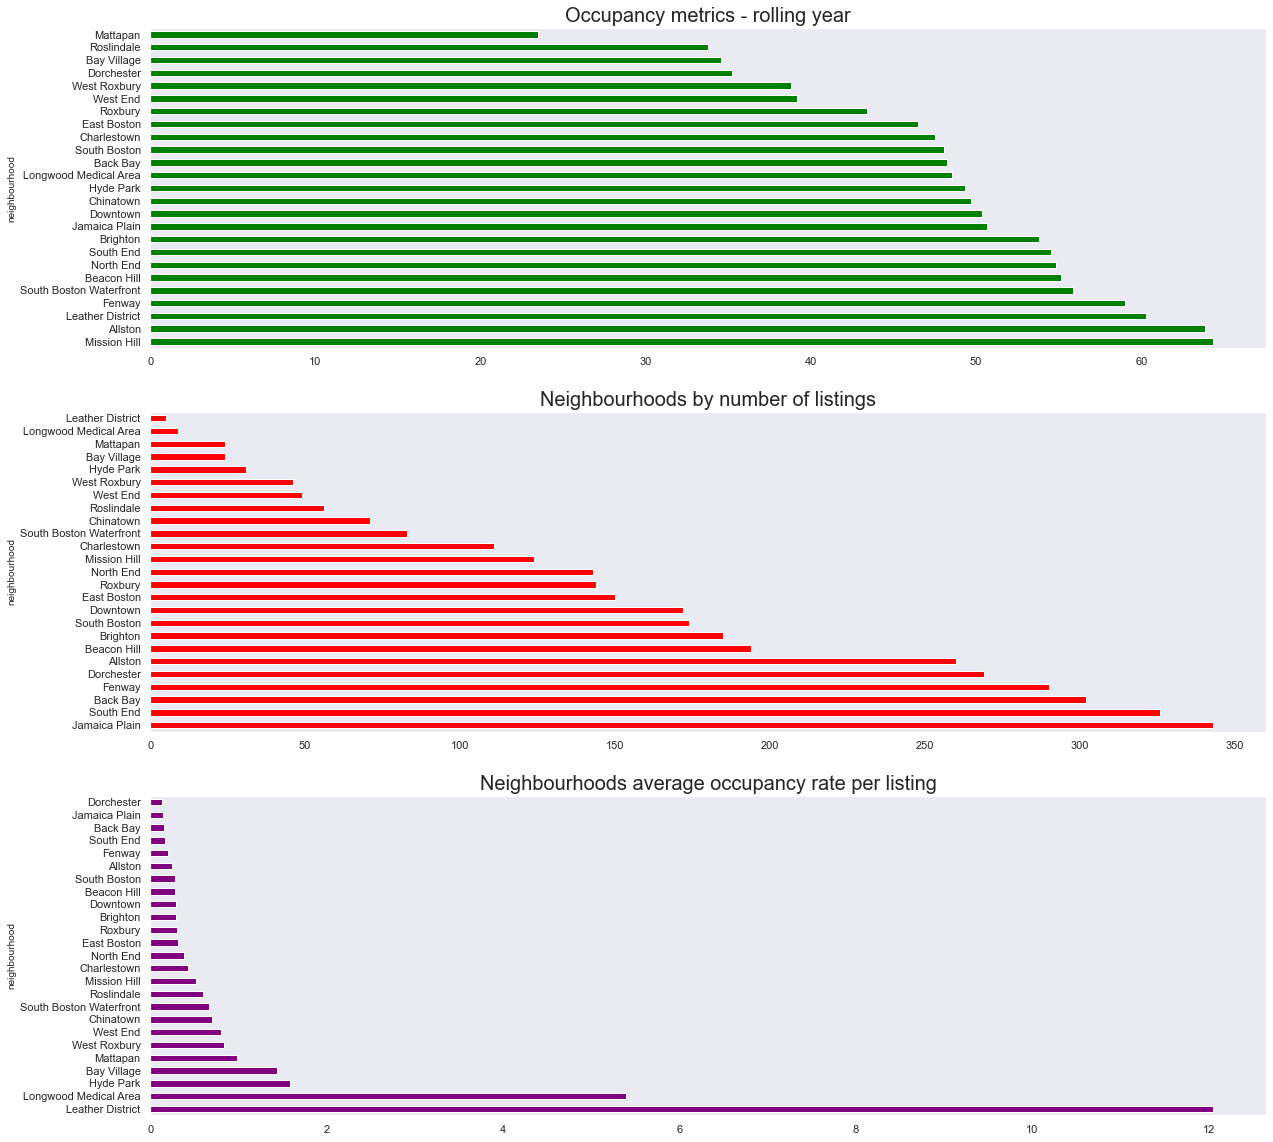

In [28]:
fig,ax=plt.subplots(nrows=3,ncols=1)

ax[0] = df.plot(ax = ax[0], kind='barh', grid=False, x = 'neighbourhood_cleansed',y = 'occupancy',color='green',figsize=(20,20))
#ax[0].set_xlabel('occupancy_metrics - rolling year', fontsize=12)
ax[0].set_ylabel('neighbourhood', fontsize=10)
ax[0].set_title('Occupancy metrics - rolling year', size=20)
ax[0].get_legend().remove()
#ax[0].get_xaxis().set_visible(False)

ax[1] = df.sort_values(by='id',ascending=False).plot(ax = ax[1],kind='barh', grid=False, x = 'neighbourhood_cleansed',y = 'id',color='red',figsize=(20,20))
#ax[1].set_xlabel('number of listings', fontsize=12)
ax[1].set_ylabel('neighbourhood', fontsize=10)
ax[1].set_title('Neighbourhoods by number of listings', size=20)
ax[1].get_legend().remove()

ax[2] = df.sort_values(by='avg_occupancy_per_listing',ascending=False).plot(ax = ax[2],kind='barh', grid=False, x = 'neighbourhood_cleansed',y = 'avg_occupancy_per_listing',color='purple',figsize=(20,20))
#ax[2].set_xlabel('average occupancy rate per listing', fontsize=12)
ax[2].set_ylabel('neighbourhood', fontsize=10)
ax[2].set_title('Neighbourhoods average occupancy rate per listing', size=20)
ax[2].get_legend().remove()


The top 5 preferred neighbourhoods by occupancy rate /number of reserved days out of the total number of available days for 365 days/ are Mission Hill, Allston, Leather District, Fenway and South Boston Waterfront.

Taking into account the number of listings per neighbourhood, the analysis could outline some potential for additional listings to be opened. The average number of listings per neighbourhood is 143.

Leather District, with the highest ratio per listing, and with the lowest number of listings, shows there is a potential for new AirBNBs to be opened, since the occupancy metrics is 20% higher that the average.
Mission Hill, with 30% higher than average occupancy, and with lower number of listings, also outlines opportunities for new listings.
South Boston Waterfront outlines additional capacity for new openings, with 43% lower number of listings.

Longwood Medical Area and Hyde Park rank around the average occupancy rate - a little above 50%. 
__For Mattapan & Bay Village I could say that the high average occupancy rate per listing is driven by the low number of listings in that area -> probably not very interesting to open new AirBNBs__


## What features define the price of the listings?

This question constitutes a regression task, that predicts the outcome of a continuous variable, i.e. predict the price of a listing, given its features. The Regression model is just the final step, beforehand I have performed certain steps in data cleaning and feature engineering, which can be found in the respective notebooks. 
After cleaning and processing the train and test set, I have used GridSearch Cross Validation over the training set, to define the best parameters of a Random Regressor Classifier. 

The question is addressed in the previous notebook, with the output of the regression model.
From data science perspective, this question constitutes a regression problem, where I am trying to predict the price of an AirBNB per person. I have used Random Forest Regression model, that predicts the price of an AirBNB per person, given its features. I have compared the Random Forest Regressor with a Linear Regression with and without Regularisation, and the Random Forest Regressor showed better performance in terms of mean squared error and R2 score. The output of the model is the price prediction, as well as the features that affect mostly the price.

The Regression model is just the final step, beforehand I have performed certain steps in data cleaning and feature engineering, which can be found in the respective notebooks in the Github documentation. After cleaning and processing the train and test set, I have used GridSearch Cross Validation over the training set, to define the best parameters of a Random Regressor Classifier.

The final metrics to evaluate the regression model, calculated on the test set, are r2 score of 30.5%, which means that the model does not describe well the variance in the price with unseen data /vs.81% on the training set/.

The RMSE /root mean squared error/ is 43.3, which is quite high again, and means that the model predicts on average price per person that is with 43$ different from the observed price. There is quite a lot room for improvement.

The top features that affect the price are the whereabouts of the AirBNBs/with latitude and longitude at the top/, the size of the cleaning fee, whether the property constitutes an Entire home, the number of reviews, as well as the reviews score etc.

As next steps I would perform:

Additional feature engineering techniques — e.g. binning of the target variable. With this, I could transform the variable into categorical one, and perform multi-class classification with the independent features, to predict in which price category they account for.<br>
Feature Selection techniques to select independent variable<br>
Boosting methods /e.g.gradient boosting/ to increase performance and reduce variance<br>
Deep learning models evaluation — whether they could provide higher goodness of fit and score better to explain the variance in the prices.